In [155]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

In [156]:
# Pre trained weights require this ordering
keras.backend.set_image_dim_ordering('th')

def model_keras():
    model = Sequential()
    
    # Layer 1
    model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 2
    model.add(Convolution2D(32,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 3
    model.add(Convolution2D(64,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 4
    model.add(Convolution2D(128,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 5
    model.add(Convolution2D(256,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 6
    model.add(Convolution2D(512,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 7
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 8
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 9
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Flatten())
    
    # Layer 10
    model.add(Dense(256))
    
    # Layer 11
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 12
    model.add(Dense(1470))
    
    return model

In [157]:
# Preprocessing
def preprocess(image):
    cropped = image[300:650,500:,:]
    resized = cv2.resize(cropped, (448,448))
    normalized = 2.0*resized/255.0 - 1
    # The model works on (channel, height, width) ordering of dimensions
    transposed = np.transpose(normalized, (2,0,1))
    return transposed

In [164]:
from weights_boxes.py import load_weights
#from weights_boxes import draw_box

model = model_keras()
load_weights(model,'yolo-tiny.weights')

In [174]:
class Box:

    def _init_(self):
        self.x = float()
        self.y = float()
        self.w = float()
        self.h = float()
        self.c = float()
        self.prob = float()


#finding overlapping with respect to width and height
def overlap(x1,w1,x2,w2):
    l1 = x1 - w1 / 2.
    l2 = x2 - w2 / 2.
    left = max(l1, l2)
    r1 = x1 + w1 / 2.
    r2 = x2 + w2 / 2.
    right = min(r1, r2)
    return right - left


#finding the area of overlapping/intersection with the help of above function
def box_intersection(a, b):
    w = overlap(a.x, a.w, b.x, b.w)
    h = overlap(a.y, a.h, b.y, b.h)
    if w < 0 or h < 0:
        return 0
    else:
        area = w * h
        return area

#finding union 
def box_union(a, b):
    i = box_intersection(a, b)
    u = a.w * a.h + b.w * b.h - i  #using A U B = A + B - intersect(A,B) 
    return u

#intersection over union is the ratio of area of intersection to the union area of two bounding boxes
def box_iou(a, b):
    return box_intersection(a, b) / box_union(a, b)


def car_boxes_from_yolo_output(out, threshold = 0.2, sqrt=1.8,C=20, B=2, S=7):
    class_num = 6  #for car class num is 6
    boxes = []
    SS        =  S * S # number of grid cells
    prob_size = SS * C # class probabilities
    conf_size = SS * B # confidences for each grid cell




    """
    output tensor is of length 1470 which is described as follows:


    1.First 980 values are the probabilities for each of the 20 classes for each grid cell. 
    These probabilities are conditioned on objects being present in each grid cell. 


    2.The next 98 values are confidence scores for 2 bounding boxes predicted by each grid cells.

    3.The next 392 values gives co-ordinates (x, y, w, h) for 2 bounding boxes per grid cell.

    The next 3 lines represent this.


    """
    probs = out[0 : prob_size]
    confs = out[prob_size : (prob_size + conf_size)]
    cords = out[(prob_size + conf_size) : ]

    #reshaping
    probs = probs.reshape([SS, C])
    confs = confs.reshape([SS, B])
    cords = cords.reshape([SS, B, 4])

    for grid in range(SS):    #looping over each grid from 0 to 48
        for b in range(B):    #looping over each 2 boxes per grid
            bx   = Box()
            bx.c =  confs[grid, b]

            """ We normalize the bounding box width & height so that they will be in 0 to 1. We paramterize the bounding box x and y
            to be offsets of a particular grid location so they are also bounded by 0 to 1 """


            bx.x = (cords[grid, b, 0] + grid %  S) / S 
            bx.y = (cords[grid, b, 1] + grid // S) / S
            bx.w =  cords[grid, b, 2] ** sqrt 
            bx.h =  cords[grid, b, 3] ** sqrt
            p = probs[grid, :] * bx.c    #class specific confidence scores(Pr(Class|Object) x Pr(Object))

            if p[class_num] >= threshold: #checking if the probability of car class is greater than threshold
                bx.prob = p[class_num]
                boxes.append(bx)


    # combine boxes that are overlap

    #arranging the boxes in the descending order of confidence scores
    boxes.sort(key=lambda b:b.prob,reverse=True)



    for i in range(len(boxes)):
        box = boxes[i]
        if box.prob == 0 or box.prob == 0.0:   #if the box doesn't detect any object skip it
            continue


        for j in range(i + 1, len(boxes)):  #looping over next box 1 ahead of previous
            box_nxt = boxes[j]

            if box_iou(box, box_nxt) >= 0.4:  #If boxes have more than 40% overlap then retain the box with the highest confidence score
                boxes[j].prob = 0.0 

    boxes = [b for b in boxes if b.prob > 0.0 or b.prob > 0] #removing all boxes with zero confidence"""


    return boxes

In [182]:

test_img = mpimg.imread('test_images/test1.jpg')
cop = np.copy(test_img)
preprocessed = preprocess(test_img)
batch = np.expand_dims(preprocessed,axis = 0)
#print(batch.shape)

In [183]:
out_batch = model.predict(batch)
print(out_batch[0])
#print(out_batch.shape)

[ 0.06177493 -0.00586925  0.02170544 ...,  0.29372877  0.21134013
  0.35693988]


In [184]:
def draw_boxes(boxes,im, crop_dim):
    imgcv1 = im.copy()
    [xmin, xmax] = crop_dim[0]
    [ymin, ymax] = crop_dim[1]
    
    height, width, _ = imgcv1.shape
    for b in boxes:
        w = xmax - xmin
        h = ymax - ymin

        left  = int ((b.x - b.w/2.) * w) + xmin
        right = int ((b.x + b.w/2.) * w) + xmin
        top   = int ((b.y - b.h/2.) * h) + ymin
        bot   = int ((b.y + b.h/2.) * h) + ymin

        if left  < 0:
            left = 0
        if right > width - 1:
            right = width - 1
        if top < 0:
            top = 0
        if bot>height - 1: 
            bot = height - 1

        thick = 5 #int((height + width // 150))

        cv2.rectangle(imgcv1, (left, top), (right, bot), (255,0,0), thick)

    return imgcv1

In [185]:
"""def draw_box(boxes,im,crop_dim):
    imgcv = np.copy(im)
    [xmin,xmax] = crop_dim[0]
    [ymin,ymax] = crop_dim[1]
    for b in boxes:
        h, w, _ = imgcv.shape
        left  = int ((b.x - b.w/2.) * w)
        right = int ((b.x + b.w/2.) * w)
        top   = int ((b.y - b.h/2.) * h)
        bot   = int ((b.y + b.h/2.) * h)
        left = int(left*(xmax-xmin)/w + xmin)
        right = int(right*(xmax-xmin)/w + xmin)
        top = int(top*(ymax-ymin)/h + ymin)
        bot = int(bot*(ymax-ymin)/h + ymin)

        if left  < 0:
            left = 0
        if right > w - 1:
            right = w - 1
        if top < 0:
            top = 0
        if bot > h - 1:
            bot = h - 1
        thick = 5
        cv2.rectangle(imgcv, (left, top), (right, bot), (0,255,0), thick)
        
    return imgcv"""

'def draw_box(boxes,im,crop_dim):\n    imgcv = np.copy(im)\n    [xmin,xmax] = crop_dim[0]\n    [ymin,ymax] = crop_dim[1]\n    for b in boxes:\n        h, w, _ = imgcv.shape\n        left  = int ((b.x - b.w/2.) * w)\n        right = int ((b.x + b.w/2.) * w)\n        top   = int ((b.y - b.h/2.) * h)\n        bot   = int ((b.y + b.h/2.) * h)\n        left = int(left*(xmax-xmin)/w + xmin)\n        right = int(right*(xmax-xmin)/w + xmin)\n        top = int(top*(ymax-ymin)/h + ymin)\n        bot = int(bot*(ymax-ymin)/h + ymin)\n\n        if left  < 0:\n            left = 0\n        if right > w - 1:\n            right = w - 1\n        if top < 0:\n            top = 0\n        if bot > h - 1:\n            bot = h - 1\n        thick = 5\n        cv2.rectangle(imgcv, (left, top), (right, bot), (0,255,0), thick)\n        \n    return imgcv'

In [190]:
boxes = car_boxes_from_yolo_output(out_batch[0], threshold=0.17)
final_out = draw_box(boxes,test_img,((500,1280),(300,650)))
#print(boxes)

In [191]:
for i in range(len(boxes)):
    print(boxes[i].prob)

0.596749
0.20833


In [192]:
#print(iou)

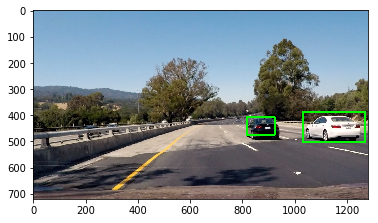

In [193]:
plt.imshow(final_out)